In [91]:
import pandas as pd
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

# 데이터 정리

In [92]:
Congestion = pd.read_csv("../data/Seoul_Congestion_week_2022.csv", encoding='cp949', index_col=0)
Elevator = pd.read_csv("../data/elevator_area.csv", index_col=0)

Transfer = pd.read_csv("../data/서울시_환승역.csv", encoding='cp949')

def preprocess_station_name(station_name):
    station_name = re.sub(r'\([^)]*\)', '', station_name)
    
    if not station_name.endswith('역'):
        station_name += '역'
    
    return station_name

Transfer['환승역명'] = Transfer['환승역명'].apply(preprocess_station_name)

Transfer.환승역명 = ["이수역" if i == "총신대입구역" else i for i in Transfer.환승역명 ]

Transfer = list(set(Transfer["환승역명"]))

In [93]:
idx = [i for i in range(len(Congestion)) if Congestion.iloc[i].역명 in Transfer]
Transfer_df = Congestion.iloc[idx]

In [94]:
# 총 환승역과 혼잡도 데이터의 환승역 차이
set(Transfer) - set(Transfer_df.역명)

{'부평구청역', '선정릉역'}

In [95]:
# 혼잡도 데이터와 엘리베이터 및 면적 데이터의 환승역 차이
set(Transfer_df.역명) - set(Elevator.역명)

{'가산디지털단지역',
 '강남구청역',
 '강남역',
 '강동역',
 '도곡역',
 '도봉산역',
 '디지털미디어시티역',
 '모란역',
 '보문역',
 '복정역',
 '상봉역',
 '석계역',
 '선릉역',
 '성수역',
 '성신여대입구역',
 '수서역',
 '신길역',
 '신내역',
 '신도림역',
 '양재역',
 '옥수역',
 '온수역',
 '이촌역',
 '창동역',
 '청량리역',
 '홍대입구역',
 '효창공원앞역'}

In [96]:
Total_df = pd.merge(Transfer_df, Elevator, how = "inner", on = "역명")
Total_df.index = Total_df["역명"]
Total_df = Total_df.loc[:,~Total_df.columns.isin(["역명"])] 

In [97]:
# Min-Max Scalering
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(Total_df)

# 클러스터 갯수 선정
- Elbow : 3개를 최적으로 추천
- Silhouette : 3개가 최적으로 보임

### => 3개로 선정

### Elbow

C:\Users\whfhr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=9), k=(1, 10))

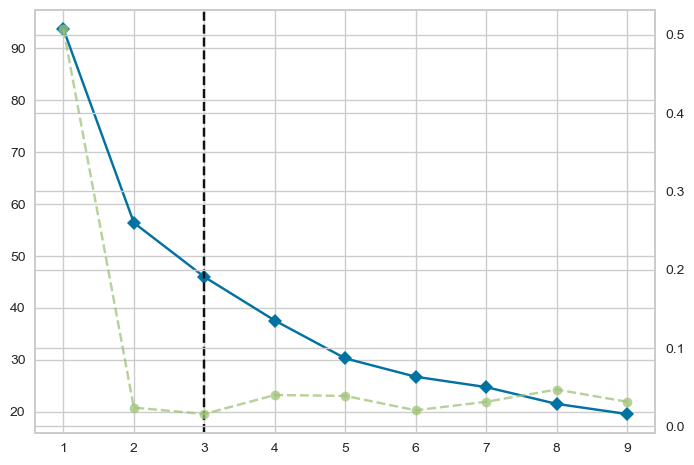

In [98]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_scale)

### 2. Silhouette

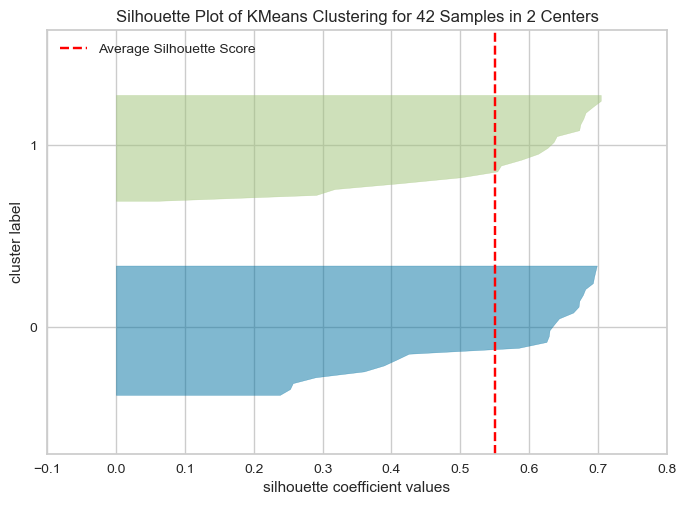

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 42 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [99]:
#클러스터링 모델 생성
kmeans_2 = KMeans(n_clusters=2, init='random')
#visualizer 생성
visualizer_2 = SilhouetteVisualizer(kmeans_2, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_2.fit(Total_df)      
visualizer_2.show()

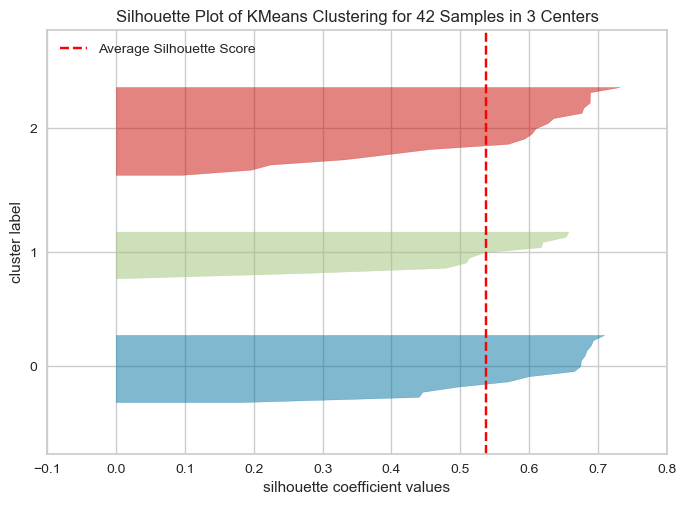

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 42 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [100]:
#클러스터링 모델 생성
kmeans_3 = KMeans(n_clusters=3, init='random')
#visualizer 생성
visualizer_3 = SilhouetteVisualizer(kmeans_3, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_3.fit(Total_df)      
visualizer_3.show()

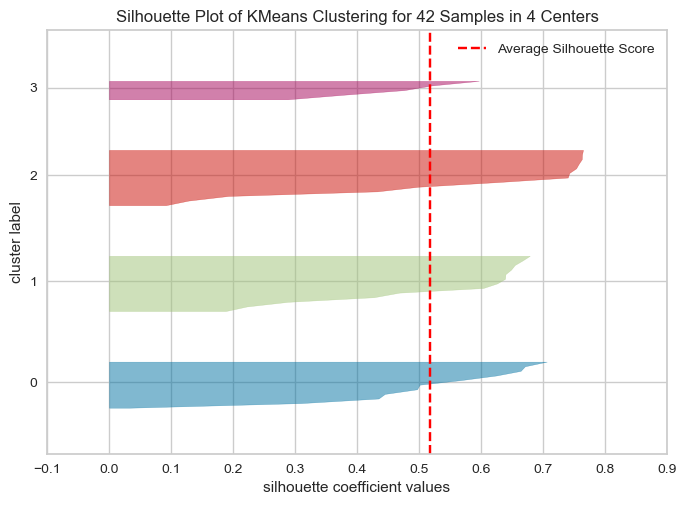

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 42 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [101]:
#클러스터링 모델 생성
kmeans_4 = KMeans(n_clusters=4, random_state=111,init='random')
#visualizer 생성
visualizer_4 = SilhouetteVisualizer(kmeans_4, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_4.fit(Total_df)      
visualizer_4.show()

# 모델링

### K-means

In [108]:
k = 3
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
Total_kmeans = Total_df.copy()
Total_kmeans['cluster'] = model.fit_predict(data_scale)

C:\Users\whfhr\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\whfhr\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


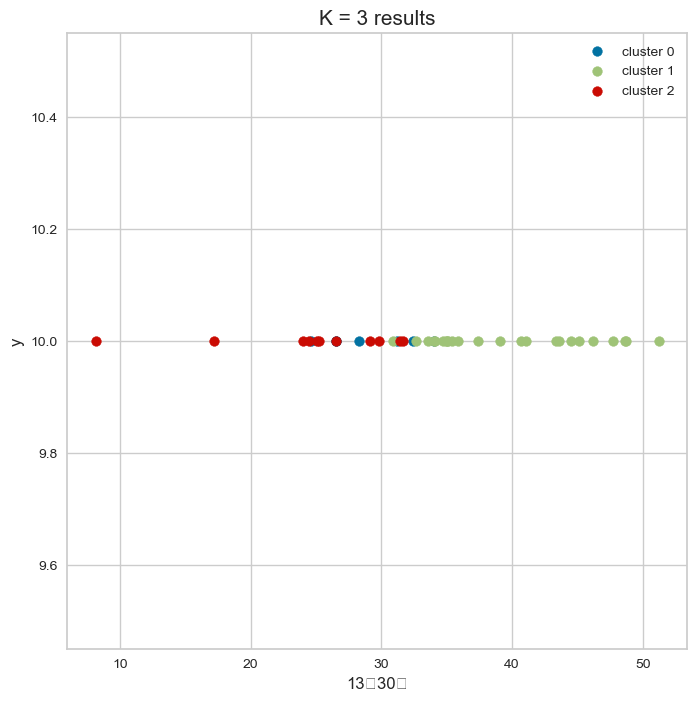

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

c = 16
for i in range(k):
    plt.scatter(Total_kmeans.loc[Total_kmeans['cluster'] == i, Total_kmeans.columns[c]], [10]*len(Total_kmeans.loc[Total_kmeans['cluster'] == i, Total_kmeans.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(Total_kmeans.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()

- cluster 0 :  
- cluster 1 : 오전시간에 혼잡도가 높은 편
- cluster 2 : 오전시간에 혼잡도가 낮은 편

In [104]:
from sklearn.mixture import GaussianMixture

In [112]:
gmm = GaussianMixture(n_components=3)
gmm.fit(Total_df)
cluster = gmm.predict(Total_df)
Total_GMM = Total_df.copy()
Total_GMM['cluster'] = cluster

C:\Users\whfhr\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\whfhr\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


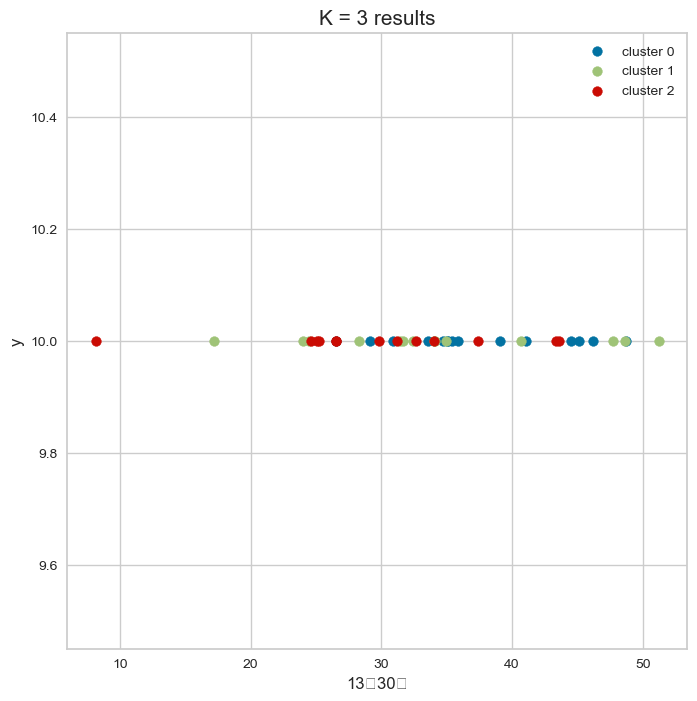

In [113]:
plt.figure(figsize = (8, 8))

c = 16
for i in range(k):
    plt.scatter(Total_GMM.loc[Total_GMM['cluster'] == i, Total_GMM.columns[c]], [10]*len(Total_GMM.loc[Total_GMM['cluster'] == i, Total_GMM.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(Total_GMM.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()